<h2>Problem Statement</h2>

<b>Can we predict if an applicant is approved for a loan, and if so, what factors influence loan approval?</b>

<h2>EDA</h2>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# For combining pipelines after encoding
from sklearn.compose import make_column_selector as selector

sns.set(style="whitegrid")

In [61]:
df = pd.read_csv('playground-series-s4e10/train.csv')
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [62]:
# Renaming columns for easier understanding
df = df.rename(columns={'cb_person_default_on_file': 'history_of_default', 'cb_person_cred_hist_length': 'cred_hist_length'})
df.head() # Confirming changes

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [63]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [64]:
# From the correlation map in previous assignments, person_age and credit_hist_length have a high correlation (> 0.88)
# This essentially shows us that these predictors measure the same thing. I will drop person_age
# Since credit_hist_length will be more directly related to loan decisions
df = df.drop(['person_age'], axis=1)
df.head()

,id,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status
0,0,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [65]:
# Using Z-Scores to remove outliers
# These predictors have outliers (maximum value for emp_length is 123)
from scipy import stats
z_emp_length = np.abs(stats.zscore(df['person_emp_length']))
print(f'Z-Scores of Employment Length:\n {z_emp_length} \n')

df['z_emp_length'] = z_emp_length
df.head() # Confirming changes

Z-Scores of Employment Length:
 0        1.187200
1        0.328047
2        0.833130
3        2.348377
4        0.682117
           ...   
58640    0.075506
58641    1.187200
58642    0.580588
58643    0.682117
58644    0.682117
Name: person_emp_length, Length: 58645, dtype: float64 



,id,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status,z_emp_length
0,0,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,1.187200
1,1,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,0.328047
2,2,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,0.833130
3,3,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,2.348377
4,4,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,0.682117


In [66]:
# +-3.00 of a Z-score is a good indicator for outliers
print(df.loc[df['z_emp_length'] >= 3.00]) # 627 rows
print(df.loc[df['z_emp_length'] <= -3.00]) # 0 rows

          id  person_income person_home_ownership  person_emp_length  \
86        86         112000              MORTGAGE               21.0   
104      104          46000              MORTGAGE               17.0   
184      184          65000              MORTGAGE               21.0   
222      222          82000              MORTGAGE               21.0   
278      278          85000              MORTGAGE               18.0   
...      ...            ...                   ...                ...   
58372  58372          96000                   OWN               17.0   
58421  58421          78000              MORTGAGE               17.0   
58460  58460          95000              MORTGAGE               17.0   
58527  58527         120000              MORTGAGE               17.0   
58609  58609          43000                  RENT               18.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
86               MEDICAL          A       5000           7.90   
104  

In [67]:
# Dropping outliers by keeping rows with Z-scores with < 3.00
df = df.loc[(df['z_emp_length'] < 3.00)]
df.shape # Confirming rows were dropped

(58018, 13)

In [68]:
df.describe(include='all')

,id,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status,z_emp_length
count,58018.000000,5.801800e+04,58018,58018.000000,58018,58018,58018.000000,58018.000000,58018.000000,58018,58018.000000,58018.000000,58018.000000
unique,NaN,NaN,4,NaN,6,7,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,N,NaN,NaN,NaN
freq,NaN,NaN,30429,NaN,12200,20721,NaN,NaN,NaN,49398,NaN,NaN,NaN
mean,29302.941311,6.390498e+04,NaN,4.537575,NaN,NaN,9208.954583,10.681245,0.159392,NaN,5.747940,0.142507,0.736980
std,16926.086284,3.778395e+04,NaN,3.588390,NaN,NaN,5551.280454,3.030996,0.091658,NaN,3.975145,0.349573,0.528945
min,0.000000,4.200000e+03,NaN,0.000000,NaN,NaN,500.000000,5.420000,0.000000,NaN,2.000000,0.000000,0.075506
25%,14636.250000,4.200000e+04,NaN,2.000000,NaN,NaN,5000.000000,7.880000,0.090000,NaN,3.000000,0.000000,0.328047
50%,29302.500000,5.800000e+04,NaN,4.000000,NaN,NaN,8000.000000,10.750000,0.140000,NaN,4.000000,0.000000,0.682117
75%,43952.750000,7.500000e+04,NaN,7.000000,NaN,NaN,12000.000000,12.990000,0.210000,NaN,8.000000,0.000000,1.085671


In [69]:
# person_income is right skewed, so using a log transformation with make it normally distributed
df['log_person_income'] = np.log1p(df['person_income'])

In [70]:
# Separating numerical and categorical variables
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'history_of_default']
num_features = ['person_income', 'log_person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cred_hist_length', 'loan_status']

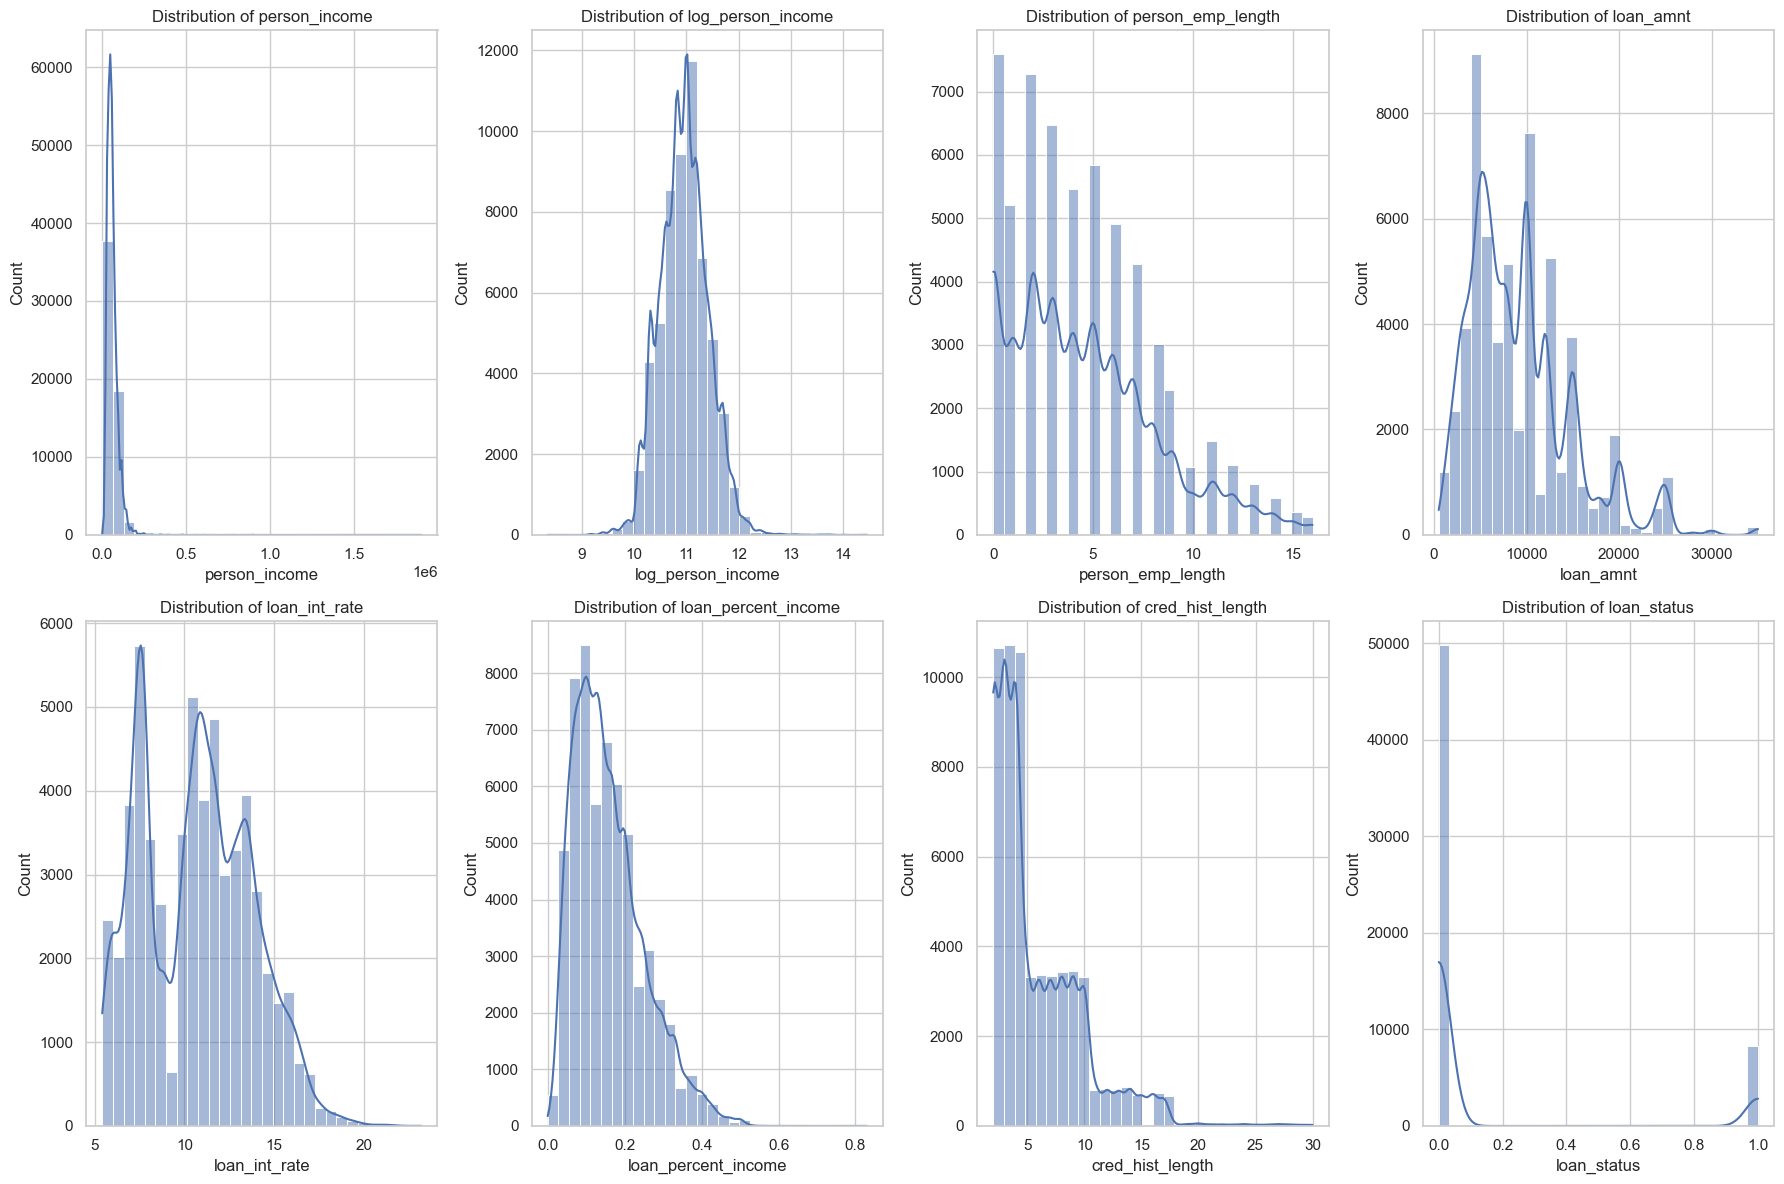

In [71]:
# Create a 2x3 grid for visualization
fig, ax = plt.subplots(2, 4, figsize=(18,12))

# Iterate over features and plot
for i, feature in enumerate(num_features):
    row, col = divmod(i, 4)
    sns.histplot(df[feature], kde=True, bins=30, ax=ax[row, col])
    ax[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

Since the data consists mostly of younger individuals, I feel as if these distributions are fairly reasonable but might need to be refined for modeling.

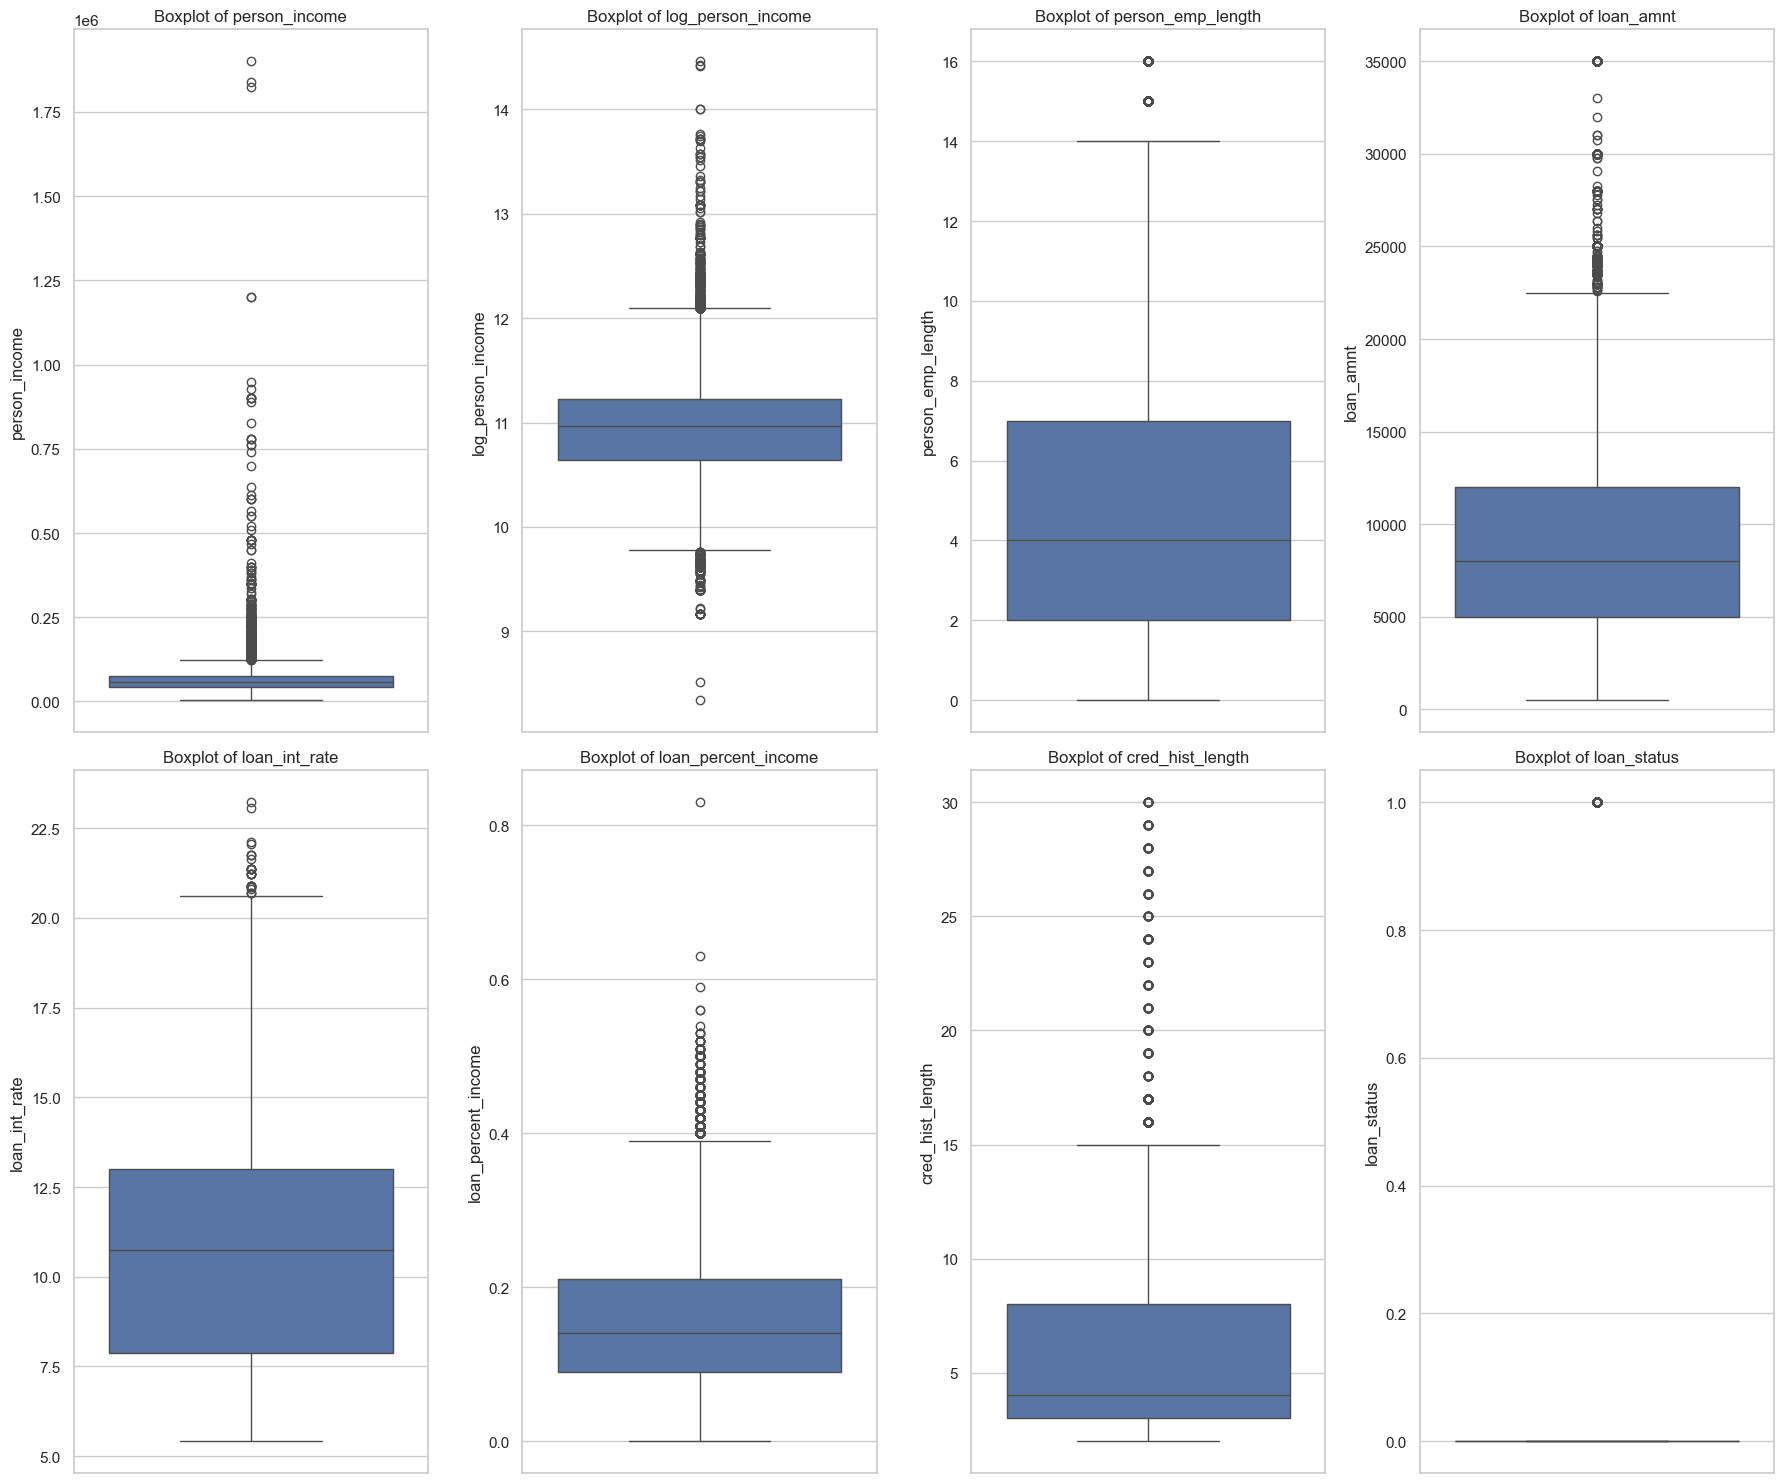

In [72]:
# Create boxplots for numerical variables
fig, ax = plt.subplots(2, 4, figsize=(18, 15))

for i, feature in enumerate(num_features):
    row, col = divmod(i, 4)
    sns.boxplot(y=df[feature], ax=ax[row, col])
    ax[row, col].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

Very similar to histograms, but we can tell outliers more clearly here. However, I didn't remove outliers (using Z-score) because I think these outliers would allow for our model to be take "random" variables better and improve predictive power.

/var/folders/qx/cv2hhpx113lf4qvjz9pfffj80000gn/T/ipykernel_63037/1443147186.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=ax[row, col], palette='magma')
/var/folders/qx/cv2hhpx113lf4qvjz9pfffj80000gn/T/ipykernel_63037/1443147186.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=ax[row, col], palette='magma')
/var/folders/qx/cv2hhpx113lf4qvjz9pfffj80000gn/T/ipykernel_63037/1443147186.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the

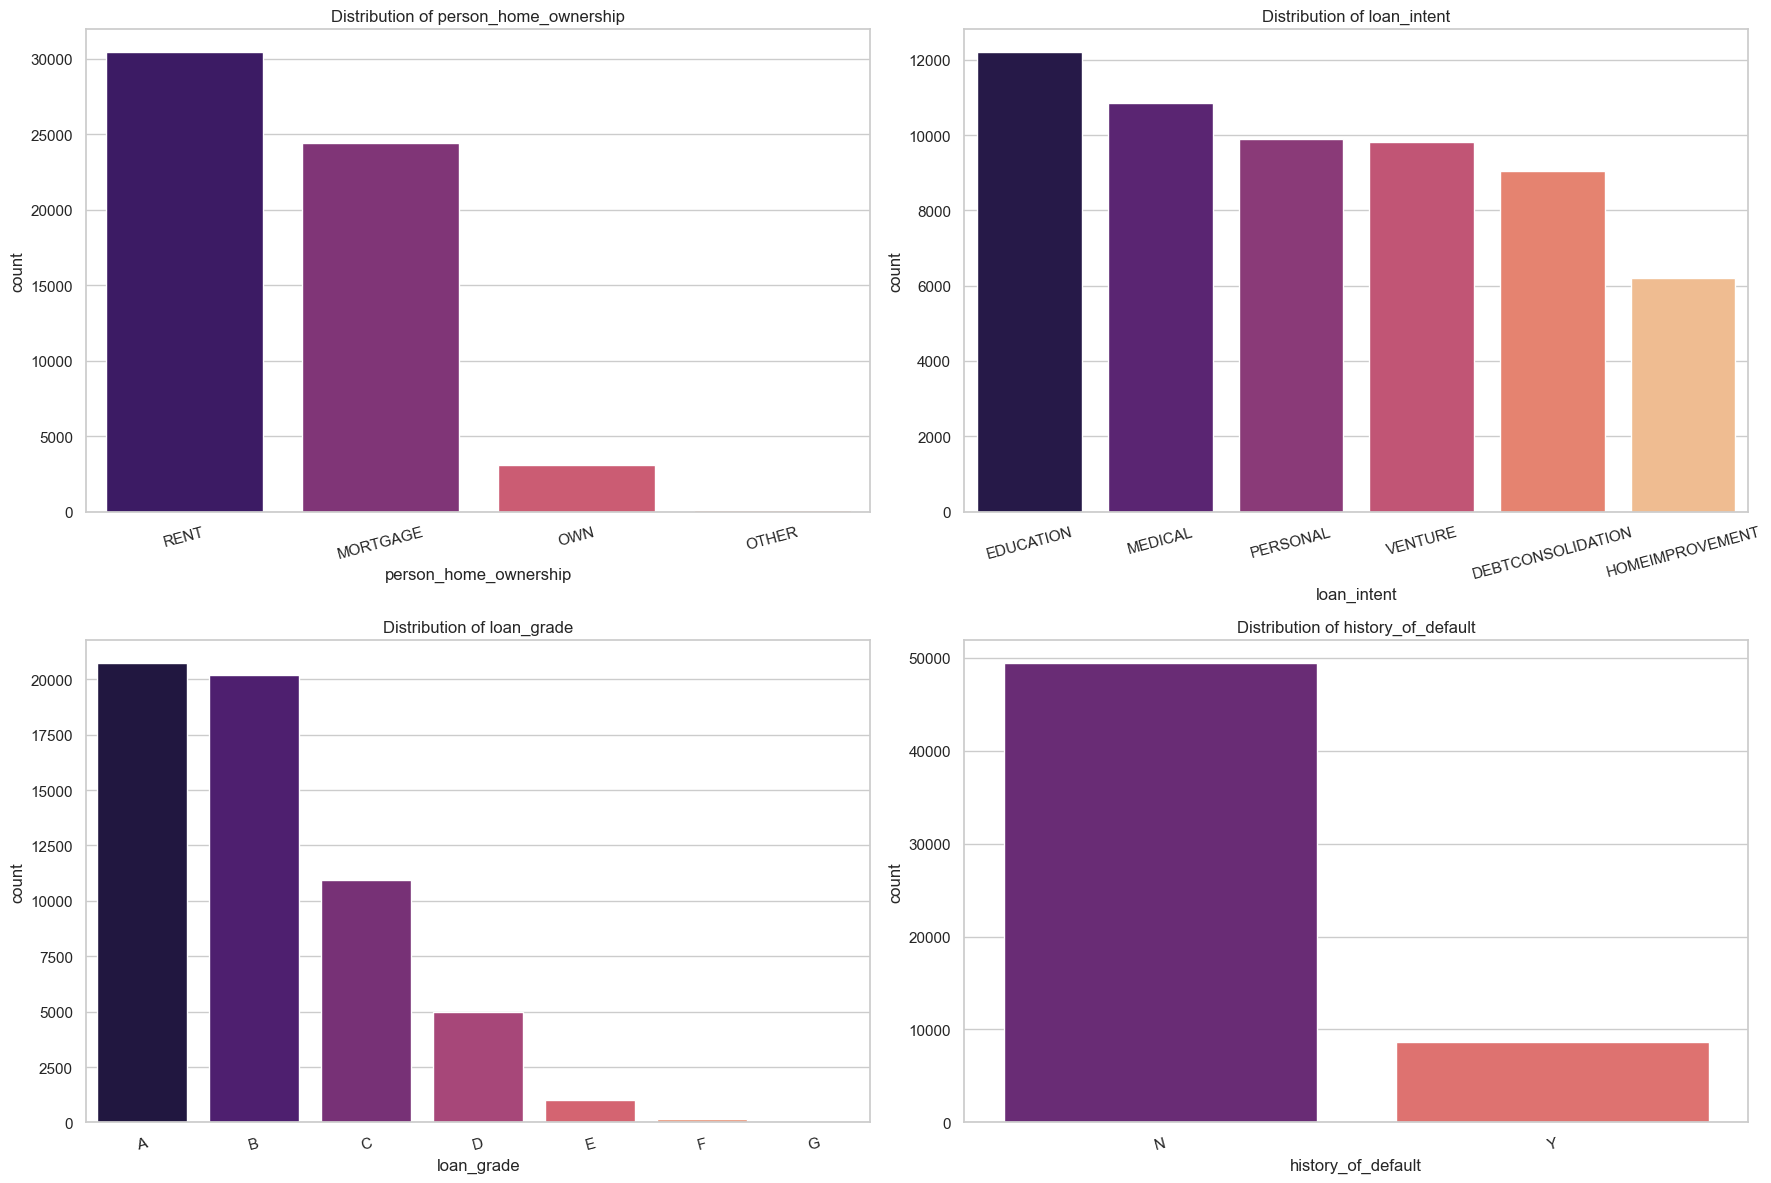

In [73]:
# Create 2x3 grid for visualization
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Iterate over categorical features and plot
for i, feature in enumerate(cat_features):
    row, col = divmod(i, 2)
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=ax[row, col], palette='magma')
    ax[row, col].set_title(f'Distribution of {feature}')
    ax[row, col].tick_params(axis='x', rotation=15)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

Individuals applying for a loan mostly rent/mortgage their home; use it for education or medical; have high loan grades; and do not have a history of default.

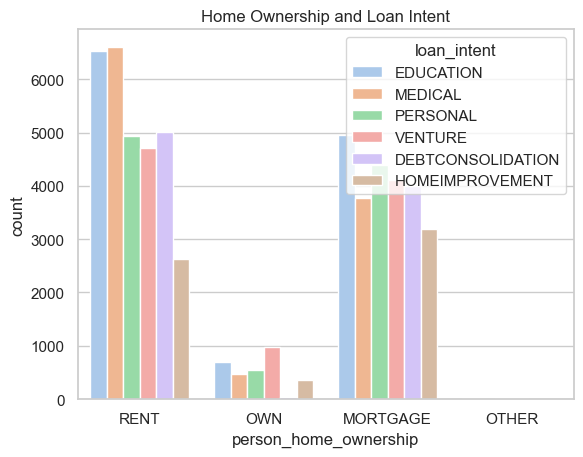

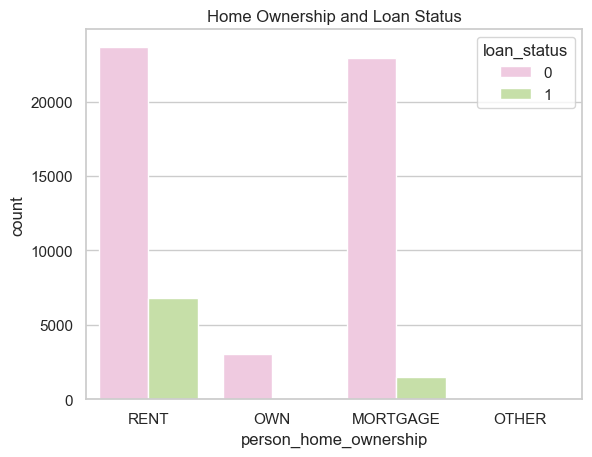

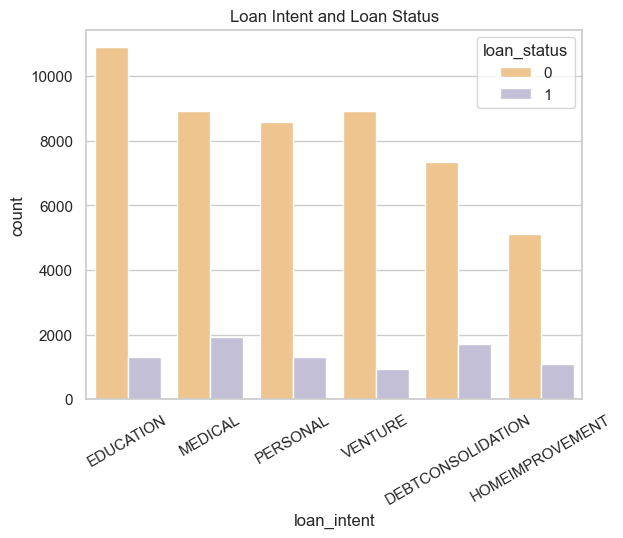

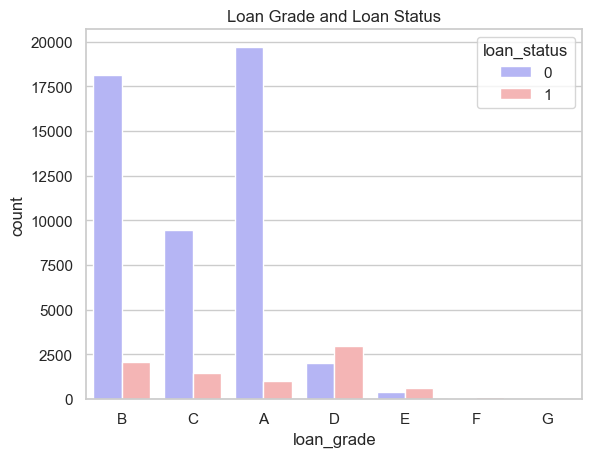

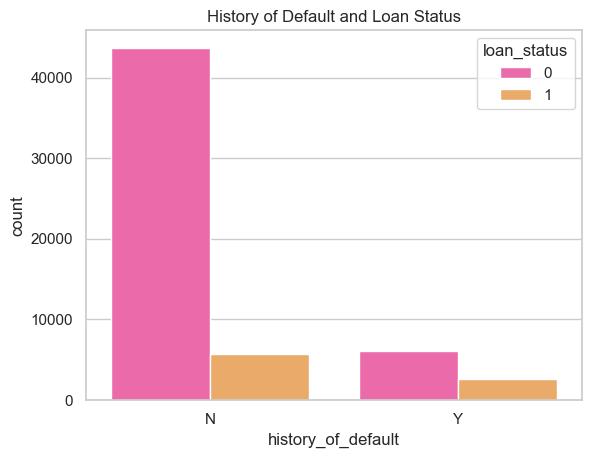

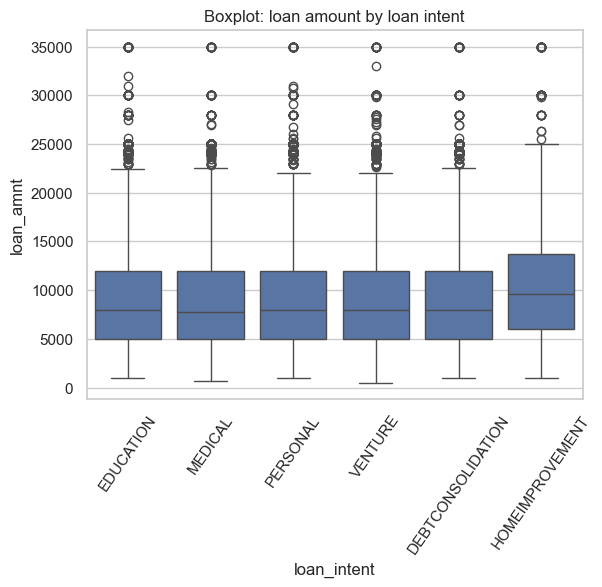

In [91]:
# Grouped bar plot for categorical vs. categorical
# Also playing around with palettes lol
sns.countplot(data=df, x='person_home_ownership', hue='loan_intent', palette='pastel')
plt.title("Home Ownership and Loan Intent")
plt.show()

sns.countplot(data=df, x='person_home_ownership', hue='loan_status', palette='PiYG')
plt.title("Home Ownership and Loan Status")
plt.show()

sns.countplot(data=df, x='loan_intent', hue='loan_status', palette='PuOr')
plt.title("Loan Intent and Loan Status")
plt.xticks(rotation=30)
plt.show()

sns.countplot(data=df, x='loan_grade', hue='loan_status', palette='bwr')
plt.title("Loan Grade and Loan Status")
plt.show()

sns.countplot(data=df, x='history_of_default', hue='loan_status', palette='spring')
plt.title("History of Default and Loan Status")
plt.show()

# Box plot for numerical vs. categorical
sns.boxplot(data=df, x='loan_intent', y='loan_amnt')
plt.title("Boxplot: loan amount by loan intent")
plt.xticks(rotation=55)
plt.show()

A lot of people who rent their homes apply for loans with a educational or medical intent. Similarly with those who mortgage their homes, but mostly apply with the intent for education and personal.

Those who rent have have a higher approval for a loan than those who mortgage, while those who own did not get approved for a loan.

Those with a medical intent appear to be approved for a loan more, however, a percentage would probably be best to determine who gets approved more (out of all intents).

Lower loan grade status (high risk) tends to get approved for a loan more, compared to high grade. This is probably because lower grades have higher interest rates.

It looks like the proportion between those with a default history and loan approval is probably higher than those without a default history and loan approval. This proportion is probably higher because those with previous default history are offered higher interest rates.

The loan amount mean and outliers across all loan intents seems to be fairly similar. 

In [92]:
# Converting categorical variables into numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['loan_grade'] = le.fit_transform(df['loan_grade']) # I think only loan grade is the best for label encoder as it is ordinal

df['person_home_ownership'] = df['person_home_ownership'].map(
    {"RENT": 1, "OWN": 2, "MORTGAGE": 3, "OTHER": 4})

df['loan_intent'] = df['loan_intent'].map(
    {"EDUCATION": 1, "MEDICAL": 2, "PERSONAL": 3, "VENTURE": 4, "DEBTCONSOLIDATION": 5, "HOMEIMPROVEMENT": 6})

df['history_of_default'] = df['history_of_default'].map(
    {"N": 0, "Y": 1})

In [93]:
df.head()

,id,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status,z_emp_length,log_person_income
0,0,35000,1,0.0,1,1,6000,11.49,0.17,0,14,0,1.187200,10.463132
1,1,56000,2,6.0,2,2,4000,13.35,0.07,0,2,0,0.328047,10.933125
2,2,28800,2,8.0,3,0,6000,8.90,0.21,0,10,0,0.833130,10.268165
3,3,70000,1,14.0,4,1,12000,11.11,0.17,0,5,0,2.348377,11.156265
4,4,60000,1,2.0,2,0,6000,6.92,0.10,0,3,0,0.682117,11.002117


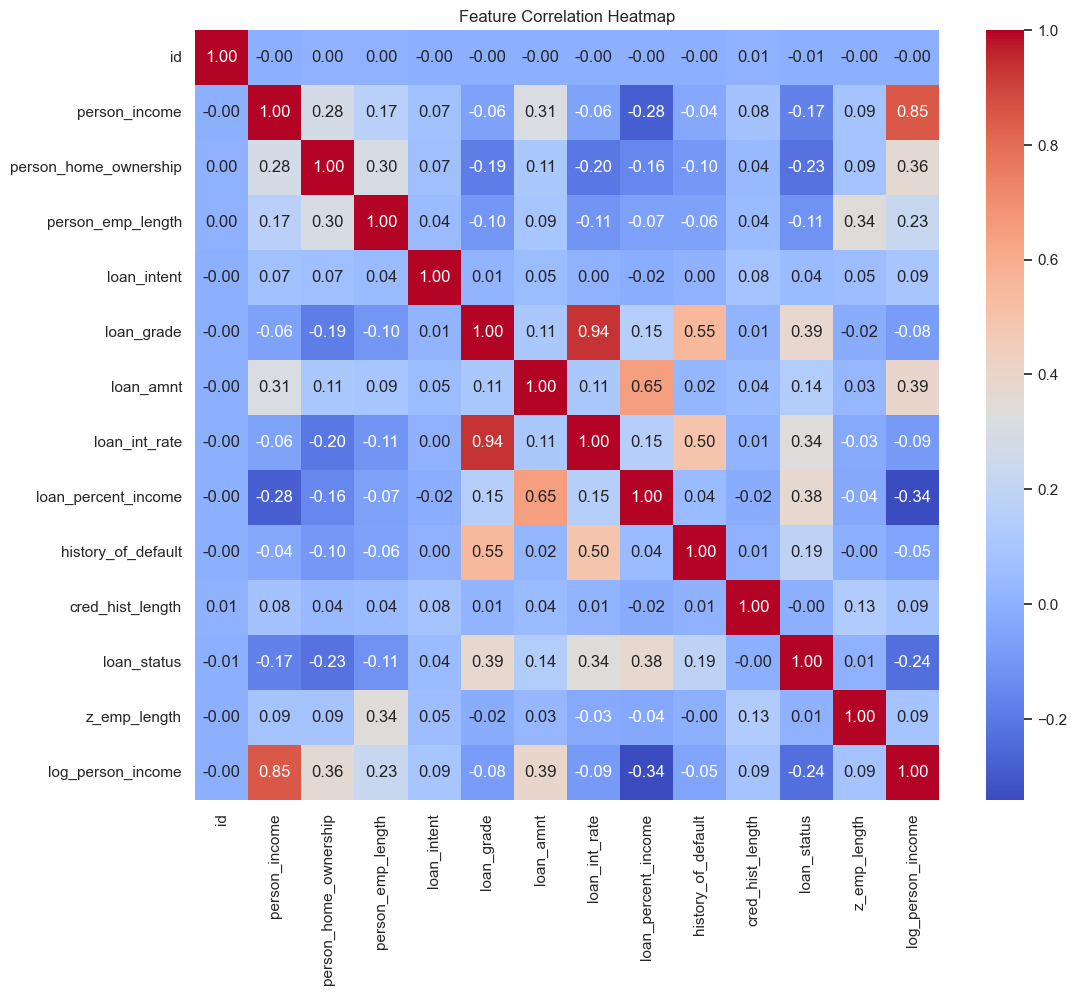

In [96]:
# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Loan grade and loan_int_rate are very highly correlated possibly suggesting multicollinearity,
# but I will proabbly keep these predictors to categorize loan grade

Features to look into for loan_status:

Positive correlation:
<li>loan_grade (0.39)</li>
<li>loan_percent_income (0.38)</li>
<li>loan_int_rate (0.34)</li>
<li>history_of_default (0.19)</li>
<li>loan_amnt (0.14)</li>

Negative correlation:
<li>log_person_income (-0.24)</li>
<li>person_home_ownership (-0.23)</li>
<li>person_emp_length (-0.11)</li>

<h2>Classification Models</h2>
<i>Because we are trying to determine if an individual will get approved for a loan</i>

<h3>Preprocessing</h3>

In [97]:
target_cols = ['loan_status']
features = [col for col in df.columns if col not in target_cols]

# Already converted all my categorical variables into numerical, making sure all numerical features are captured
num_features = [col for col in features if df[col].dtype != "object"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features) # Numeric features being processed; scales num features while reducing effect of outliers using median and IQR
    ],
    sparse_threshold=0
)

X_processed = preprocessor.fit_transform(df[features])

df_transformed = pd.DataFrame(X_processed, columns=num_features)
print(df_transformed.head()) # All numerical features scaled to a consistent range

         id  person_income  person_home_ownership  person_emp_length  \
0 -0.999522      -0.696970                    0.0               -0.8   
1 -0.999488      -0.060606                    0.5                0.4   
2 -0.999454      -0.884848                    0.5                0.8   
3 -0.999420       0.363636                    0.0                2.0   
4 -0.999386       0.060606                    0.0               -0.4   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0    -0.666667         0.0  -0.285714       0.144814             0.250000   
1    -0.333333         0.5  -0.571429       0.508806            -0.583333   
2     0.000000        -0.5  -0.285714      -0.362035             0.583333   
3     0.333333         0.0   0.571429       0.070450             0.250000   
4    -0.333333        -0.5  -0.285714      -0.749511            -0.333333   

   history_of_default  cred_hist_length  z_emp_length  log_person_income  
0                 0.0        

In [107]:
# Split features and targets
X_processed = df_transformed

y_class = df['loan_status'].astype(int)  # Ensure binary target is integer (0/1)

# Split into training and test sets (70/30 split)
# we are using the same training set but distinct targets for the classification & regression models
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_class, test_size=0.3, random_state=4, stratify=y_class) # Prevents class imbalance

# Could probably use test.csv data to train model

<h3>Decision Tree</h3>

In [119]:
# Might have to do this with person_income instead of log_person_income
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=50,max_depth=5)
dt_clf.fit(X_train, y_train)
y_pred_dt_clf = dt_clf.predict(X_test)
acc_dt_clf = accuracy_score(y_test, y_pred_dt_clf)
print("Decision Tree Classifier Accuracy:", acc_dt_clf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt_clf))

Decision Tree Classifier Accuracy: 0.9391589107204412
Confusion Matrix:
 [[14664   262]
 [  797  1683]]


<h3>Decision Tree Visualization</h3>

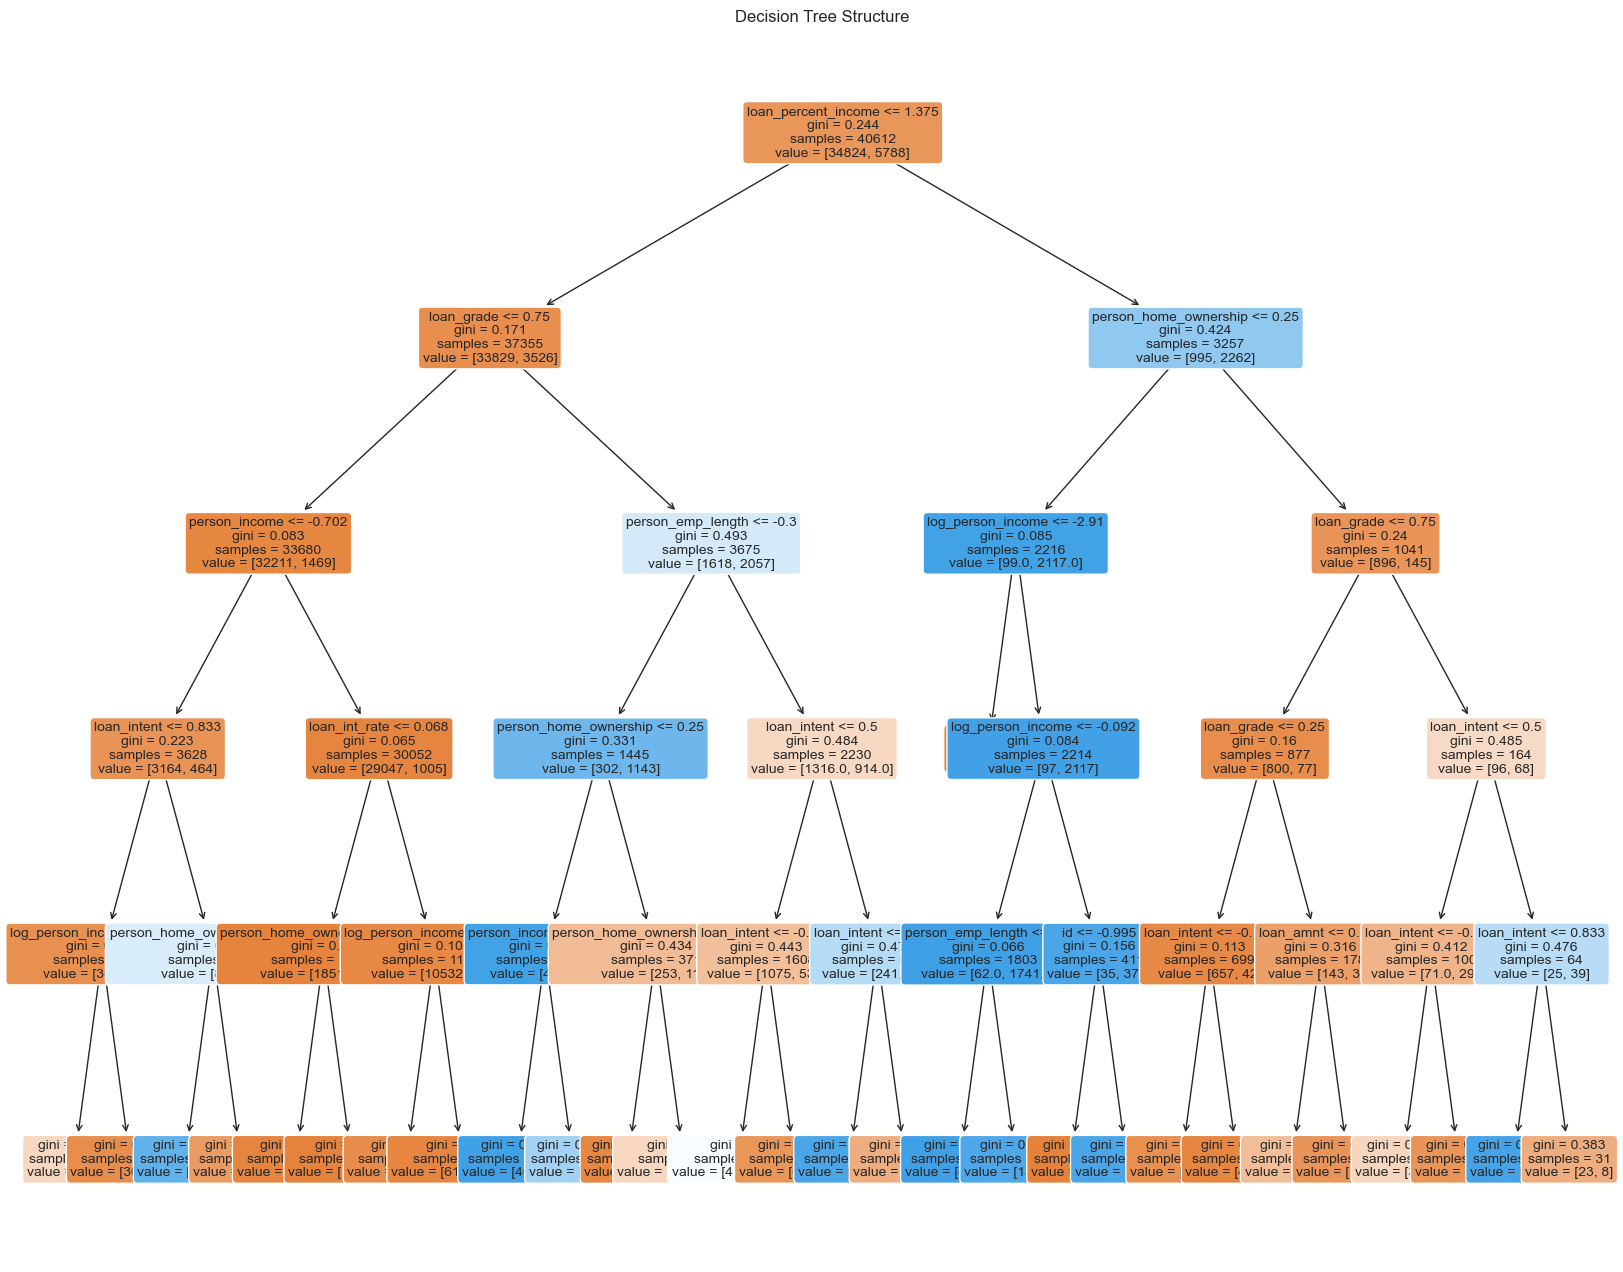

In [122]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 16))
plot_tree(dt_clf, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

<h3>Random Forest Classifier</h3>

In [117]:
# Might have to do this with person_income instead of log_person_income
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf_clf = rf_clf.predict(X_test)
acc_rf_clf = accuracy_score(y_test, y_pred_rf_clf)
print("Random Forest Classifier Accuracy:", acc_rf_clf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_clf))

Random Forest Classifier Accuracy: 0.9489831092726646
Confusion Matrix:
 [[14769   157]
 [  731  1749]]


<h3>Logistic Regression</h3>

Logistic Regression Accuracy: 0.898770538894634


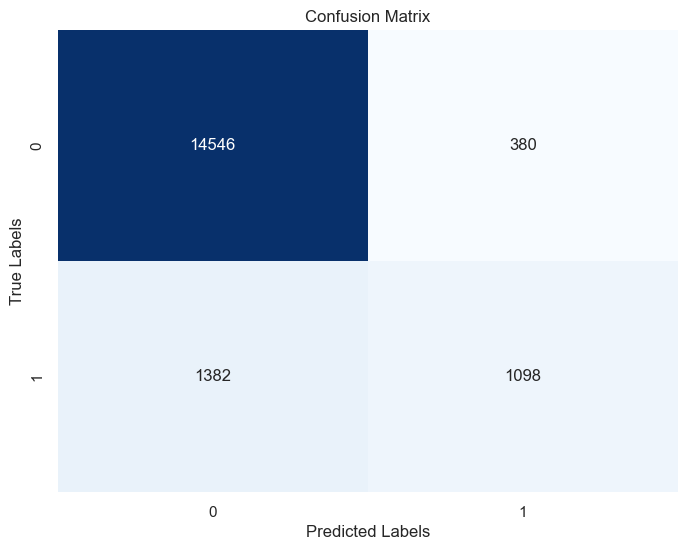

Precision: 0.7428958051420839
Recall: 0.442741935483871
F1-Score: 0.5548256695300657


In [116]:
# Logistic Regression for Classification
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

acc_log = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Accuracy:", acc_log)

cm =  confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(y_test, y_pred_log)
recall = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)
##roc_auc = roc_auc_score(y_class_test, y_prob_class)  # Typically y_prob_class[:,1] if using predict_proba

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
#print("ROC-AUC:", roc_auc)

<h3>Linear SVC</h3>

<h3>Naive Bayes</h3>

<h3>KNeighbors Classifier</h3>

<h2>Log Odds for Logistic Regression</h2>

In [123]:
log_odds = log_reg.coef_  # This returns a 2D array (for binary classification, shape is (1, n_features))
log_odds_series = pd.Series(log_odds[0], index=X_train.columns)
print("Logistic Regression Log Odds:")
print(log_odds_series.sort_values(ascending=False))

# The sign and magnitude of each log-odds coefficient indicate how a one-unit
# change in the feature affects the log odds of being in the positive class

Logistic Regression Log Odds:
loan_grade               2.404940
loan_percent_income      1.361939
loan_intent              0.414885
z_emp_length             0.200210
person_income            0.077113
cred_hist_length        -0.001556
id                      -0.042204
person_emp_length       -0.138033
history_of_default      -0.152823
loan_amnt               -0.189649
loan_int_rate           -0.264559
log_person_income       -0.445628
person_home_ownership   -1.138623
dtype: float64
